In [2]:
from paddleocr import PPStructure, PaddleOCR

layout_model = PPStructure(table=False, ocr=False, lang="en")
ocr_model = PaddleOCR(ocr=True, lang="en", ocr_version="PP-OCRv3")

[2023/04/27 16:30:54] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\matsulab_kato/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\matsulab_kato/.paddleocr/whl\\rec\\en\\en_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_te

In [3]:
from pdf2image import convert_from_path
import os

pdf_path = os.path.join(os.getcwd(), "sample.pdf")
pdf_image = convert_from_path(pdf_path, dpi=300, last_page=2)

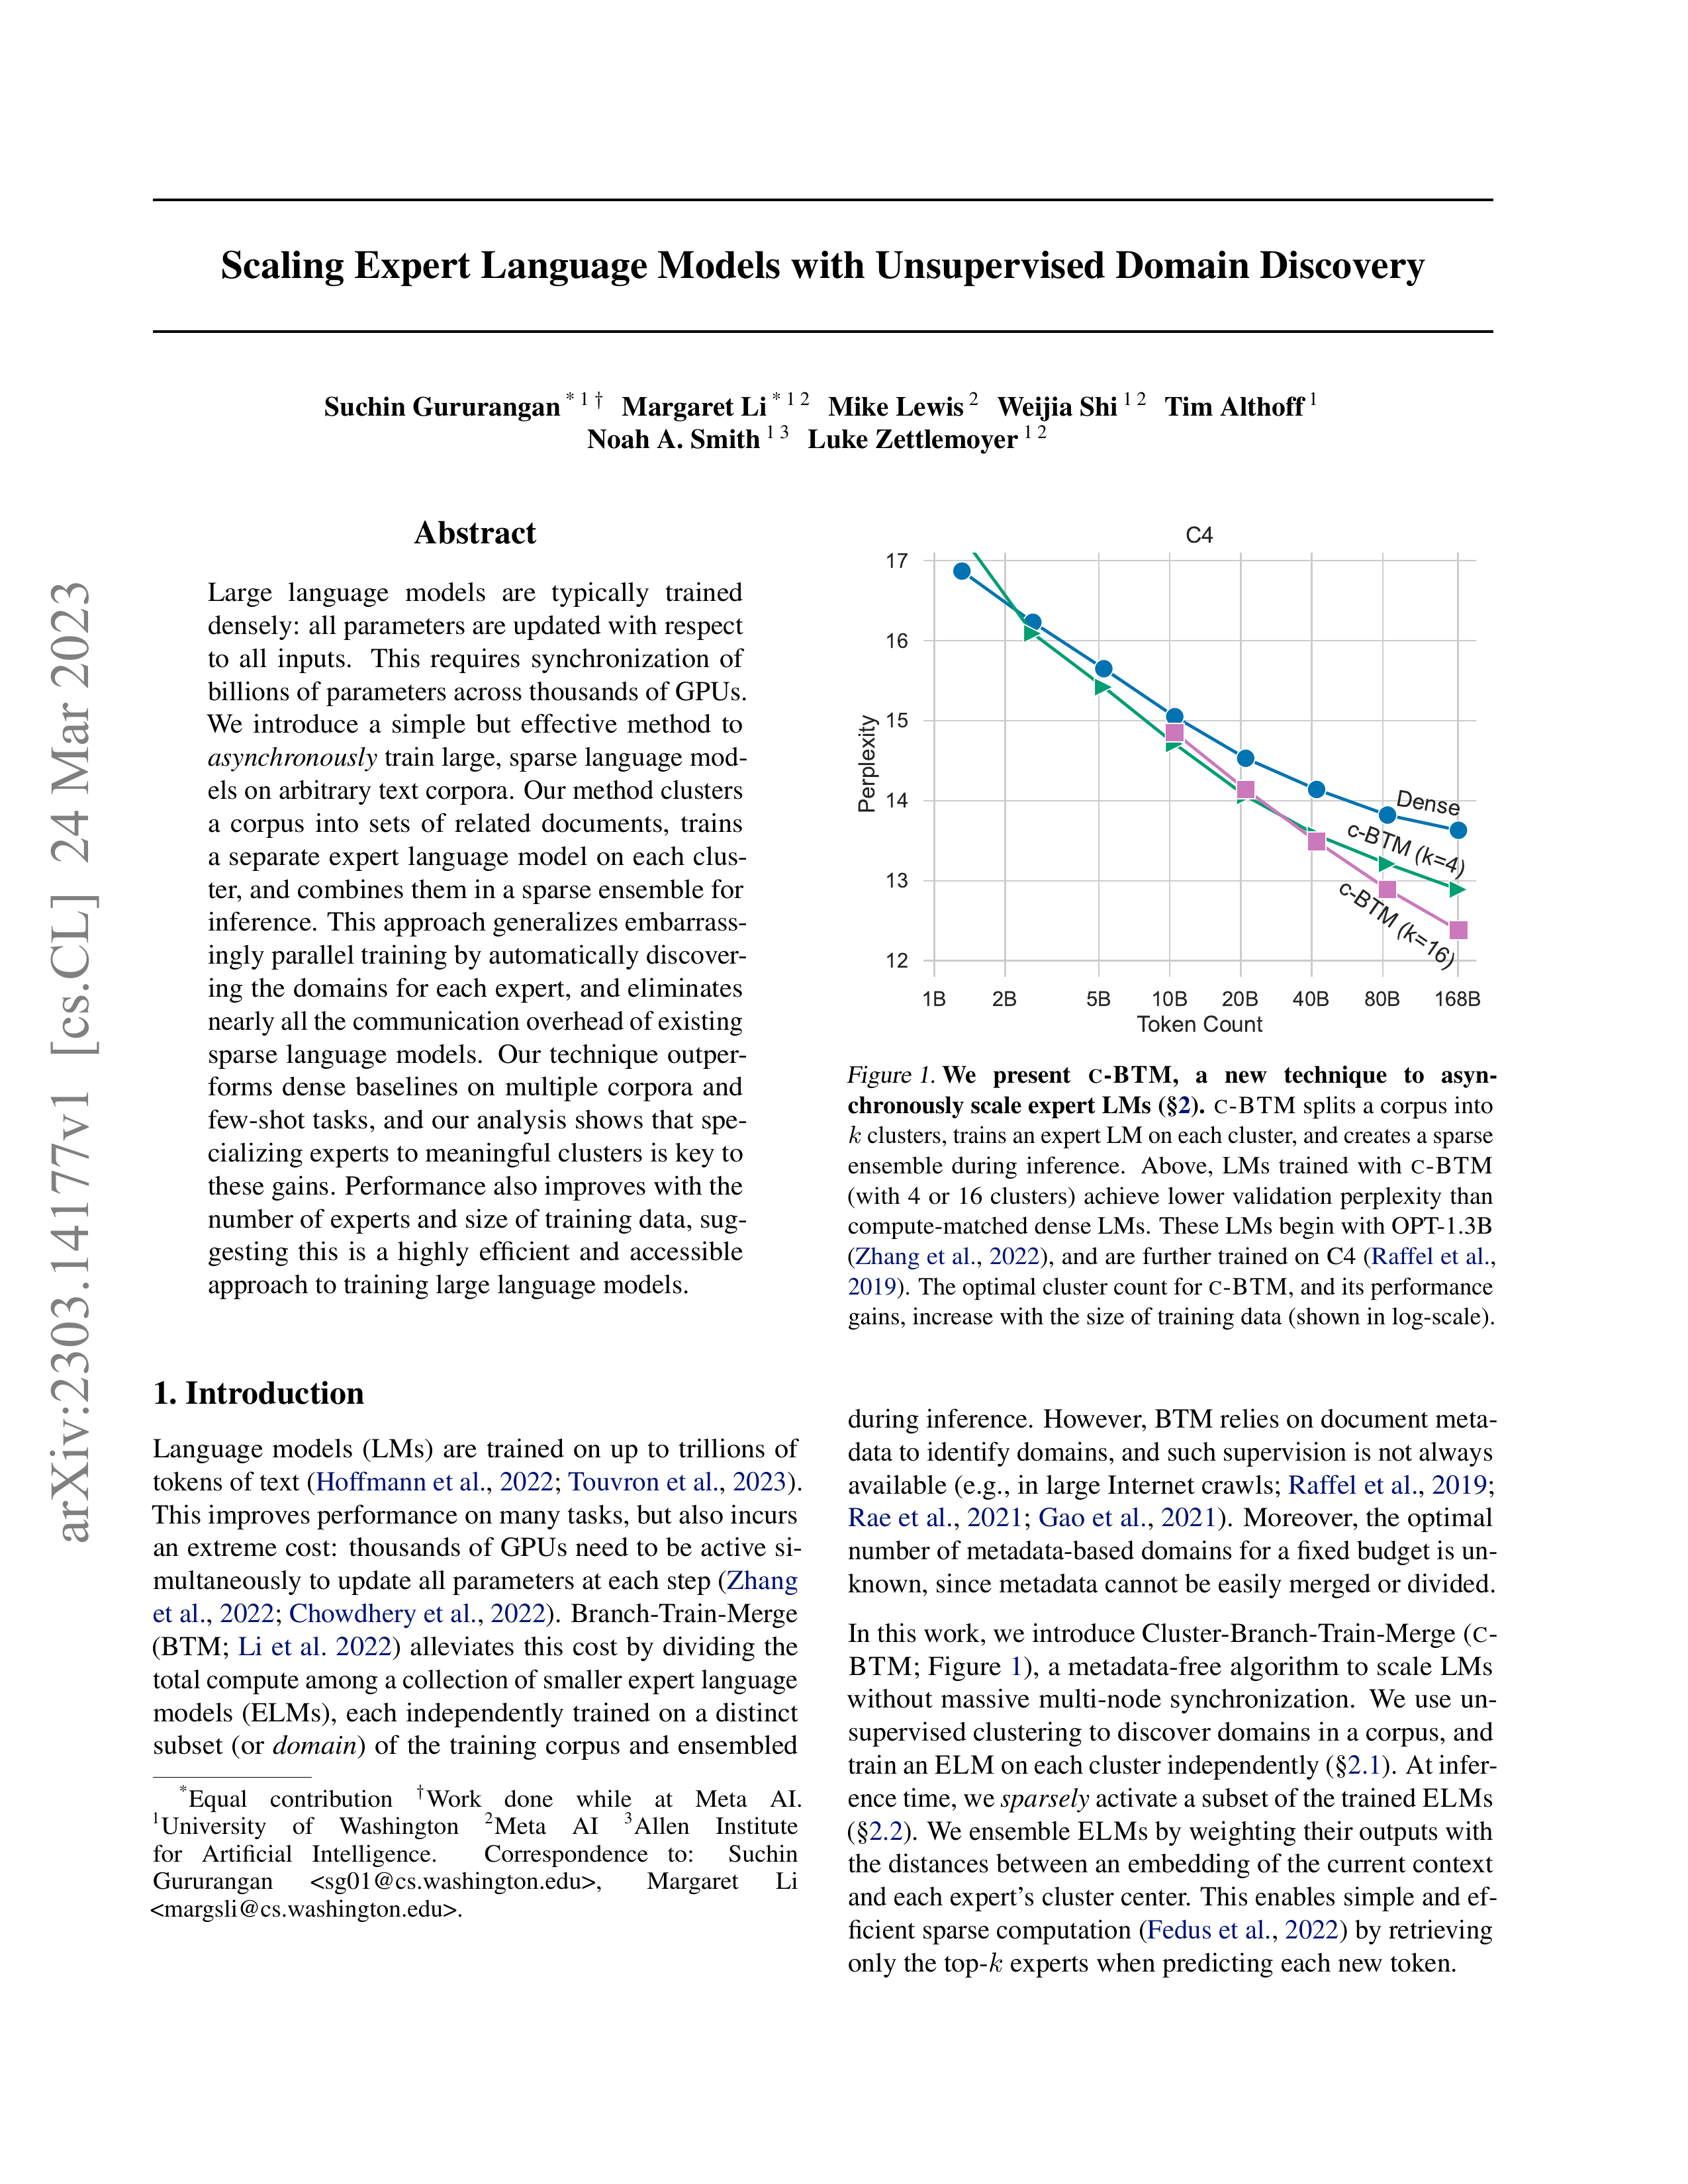

In [5]:
pdf_image[0]

In [6]:
import numpy as np

sample_img = np.array(pdf_image[0], dtype=np.uint8)
a = layout_model(sample_img)

In [7]:
type(pdf_image[0])

PIL.PpmImagePlugin.PpmImageFile

In [8]:
type(a)

list

In [9]:
a[10]["type"]

'figure'

In [14]:
sample = []
for part in a:
    if part["type"] == "text":
        i = part["img"]
        c = ocr_model(part["img"])
        ocr_text = list(map(lambda x: x, ocr_model(part["img"])))[1]
        break

[2023/04/27 16:37:27] ppocr DEBUG: dt_boxes num : 9, elapse : 0.2081160545349121
[2023/04/27 16:37:31] ppocr DEBUG: rec_res num  : 9, elapse : 3.471714496612549
[2023/04/27 16:37:31] ppocr DEBUG: dt_boxes num : 9, elapse : 0.20049309730529785
[2023/04/27 16:37:34] ppocr DEBUG: rec_res num  : 9, elapse : 3.4218485355377197


In [15]:
ocr_text

[('Figure 1. We present C-BTM, a new technique to asyn-', 0.9808053374290466),
 ('chronously scale expert LMs (s2). C-BTM splits a corpus into',
  0.978239893913269),
 ('k clusters, trains an expert LM on each cluster, and creates a sparse',
  0.9869077205657959),
 ('ensemble during inference. Above, LMs trained with C-BTM',
  0.993188202381134),
 ('(with 4 or 16 clusters) achieve lower validation perplexity than',
  0.986068844795227),
 ('compute-matched dense LMs. These LMs begin with OPT-1.3B',
  0.98800128698349),
 ('Zhang et al., 2022), and are further trained on C4 (Raffel et al.',
  0.9816380143165588),
 ('2019). The optimal cluster count for C-BTM, and its performance',
  0.9938991069793701),
 ('gains, increase with the size of training data (shown in log-scale).',
  0.9902660250663757)]

In [17]:
ocr_text[0]
oc = " ".join(list(s[0] for s in ocr_text))
oc

'Figure 1. We present C-BTM, a new technique to asyn- chronously scale expert LMs (s2). C-BTM splits a corpus into k clusters, trains an expert LM on each cluster, and creates a sparse ensemble during inference. Above, LMs trained with C-BTM (with 4 or 16 clusters) achieve lower validation perplexity than compute-matched dense LMs. These LMs begin with OPT-1.3B Zhang et al., 2022), and are further trained on C4 (Raffel et al. 2019). The optimal cluster count for C-BTM, and its performance gains, increase with the size of training data (shown in log-scale).'

In [63]:
import re
reg = re.compile("- ")
cleaned_text = reg.sub("", oc)

In [64]:
cleaned_text

'Figure 1. We present C-BTM, a new technique to asynchronously scale expert LMs (s2). C-BTM splits a corpus into k clusters, trains an expert LM on each cluster, and creates a sparse ensemble during inference. Above, LMs trained with C-BTM (with 4 or 16 clusters) achieve lower validation perplexity than compute-matched dense LMs. These LMs begin with OPT-1.3B Zhang et al., 2022), and are further trained on C4 (Raffel et al. 2019). The optimal cluster count for C-BTM, and its performance gains, increase with the size of training data (shown in log-scale).'

In [65]:
import os 
from transformers import pipeline
model_name = "staka/fugumt-en-ja"
model_path = os.path.join(os.getcwd(), "model", model_name)
pipe = pipeline("translation", model=model_path, device="cuda:0")

In [67]:
a = pipe(cleaned_text)

In [76]:
bb = a[0]["translation_text"]

In [129]:
from PIL import Image, ImageDraw, ImageFont

block = Image.new("RGB",
                  (
                    part["bbox"][2] - part["bbox"][0] + 7,
                    part["bbox"][3] - part["bbox"][1],
                  ),
                  color=(255, 255, 255)
                  )

In [130]:
canvas = ImageDraw.Draw(block)

In [131]:
import sys
import textwrap
import unicodedata
from itertools import groupby

MAXWIDTH = 70

# copy from docutils
east_asian_widths = {
    "W": 2,  # Wide
    "F": 2,  # Full-width (wide)
    "Na": 1,  # Narrow
    "H": 1,  # Half-width (narrow)
    "N": 1,  # Neutral (not East Asian, treated as narrow)
    "A": 1,
}  # Ambiguous (s/b wide in East Asian context,
# narrow otherwise, but that doesn't work)

# copy from docutils
def column_width(text):
    """Return the column width of text.
    Correct ``len(text)`` for wide East Asian and combining Unicode chars.
    """
    if isinstance(text, str) and sys.version_info < (3, 0):
        return len(text)
    combining_correction = sum([-1 for c in text if unicodedata.combining(c)])
    try:
        width = sum([east_asian_widths[unicodedata.east_asian_width(c)] for c in text])
    except AttributeError:  # east_asian_width() New in version 2.4.
        width = len(text)
    return width + combining_correction


class TextWrapper(textwrap.TextWrapper):
    """Custom subclass that uses a different word splitter."""

    def _wrap_chunks(self, chunks):
        """_wrap_chunks(chunks : [string]) -> [string]
        Original _wrap_chunks use len() to calculate width.
        This method respect to wide/fullwidth characters for width adjustment.
        """
        lines = []
        if self.width <= 0:
            raise ValueError("invalid width %r (must be > 0)" % self.width)

        chunks.reverse()

        while chunks:
            cur_line = []
            cur_len = 0

            if lines:
                indent = self.subsequent_indent
            else:
                indent = self.initial_indent

            width = self.width - column_width(indent)

            if self.drop_whitespace and chunks[-1].strip() == "" and lines:
                del chunks[-1]

            while chunks:
                l = column_width(chunks[-1])

                if cur_len + l <= width:
                    cur_line.append(chunks.pop())
                    cur_len += l

                else:
                    break

            if chunks and column_width(chunks[-1]) > width:
                self._handle_long_word(chunks, cur_line, cur_len, width)

            if self.drop_whitespace and cur_line and cur_line[-1].strip() == "":
                del cur_line[-1]

            if cur_line:
                lines.append(indent + "".join(cur_line))

        return lines

    def _break_word(self, word, space_left):
        """_break_word(word : string, space_left : int) -> (string, string)
        Break line by unicode width instead of len(word).
        """
        total = 0
        for i, c in enumerate(word):
            total += column_width(c)
            if total > space_left:
                return word[: i - 1], word[i - 1 :]
        return word, ""

    def _split(self, text):
        """_split(text : string) -> [string]
        Override original method that only split by 'wordsep_re'.
        This '_split' split wide-characters into chunk by one character.
        """
        split = lambda t: textwrap.TextWrapper._split(self, t)
        chunks = []
        for chunk in split(text):
            for w, g in groupby(chunk, column_width):
                if w == 1:
                    chunks.extend(split("".join(g)))
                else:
                    chunks.extend(list(g))
        return chunks

    def _handle_long_word(self, reversed_chunks, cur_line, cur_len, width):
        """_handle_long_word(chunks : [string],
                             cur_line : [string],
                             cur_len : int, width : int)
        Override original method for using self._break_word() instead of slice.
        """
        space_left = max(width - cur_len, 1)
        if self.break_long_words:
            l, r = self._break_word(reversed_chunks[-1], space_left)
            cur_line.append(l)
            reversed_chunks[-1] = r

        elif not cur_line:
            cur_line.append(reversed_chunks.pop())


def fw_wrap(text, width=MAXWIDTH, **kwargs):
    w = TextWrapper(width=width, **kwargs)
    return w.wrap(text)


def fw_fill(text, width=MAXWIDTH, **kwargs):
    w = fw_wrap(text=text, width=width, **kwargs)
    return "\n".join(w)

## 文章の改行

In [132]:
p_text = fw_fill(bb, width=int(
    (part["bbox"][2] - part["bbox"][0]) / (32 / 2) -1
))

In [133]:
p_text

'図1. 専門家LMを非同期にスケールするC-BTM(s2)。C-BTMは、コー\nパスをkクラスタに分割し、各クラスタで専門家LMをトレーニング\nし、推論中にスパースアンサンブルを作成する。上記の上で、\nC-BTM(4または16クラスタ)でトレーニングされたLMは、計算にマッ\nチした高密度LMよりも低い検証パープレキシティを達成する。これ\nらのLMはOPT-1.3B Zhang et al., 2022で始まり、C4(Raffel et\nal. 2019)でさらに訓練される。C-BTMの最適なクラスタ数とその性\n能向上は、トレーニングデータのサイズ(ログスケールで示される)\nによって増加する。'

In [134]:
font = ImageFont.truetype(
            "C:\my_folder\prac\model\SourceHanSerifK-Light.otf",
            size=32)
canvas.text(
    (0, 0),
    text=p_text,
    font=font,
    fill=(0, 0, 0)
)

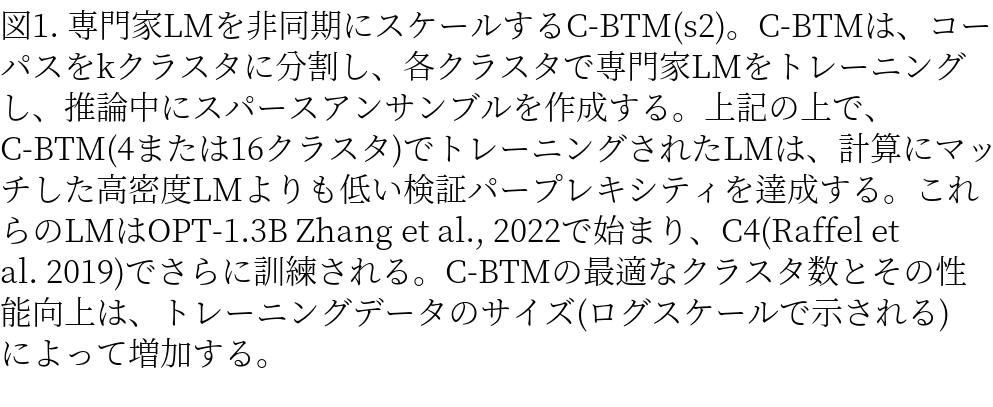

In [135]:
block

In [142]:

tmp = np.array(pdf_image[0])
tmp

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [144]:
tmp[
    int(part["bbox"][1]) : int(part["bbox"][3]),
    int(part["bbox"][0]) : int(part["bbox"][2] + 7),
] = np.array(block)

In [151]:
abb = Image.fromarray(tmp)
bbb = Image.fromarray(tmp)


In [153]:
os.mkdir("tmp")
abb.save("tmp/test.pdf")

In [136]:
import os
import re
import glob
import copy
import torch
from pdf2image import convert_from_path
from PIL import Image, ImageDraw, ImageFont
from paddleocr import PPStructure, PaddleOCR
from transformers import pipeline
class PdfTranslate:
    def __init__(self):
        self.dpi = 300
        self.font_size = 32
        self.model_name = "staka/fugumt-en-ja"
        self.currnt_dir = os.getcwd()
        self.model_path = os.path.join(self.currnt_dir, "model", self.model_name)
        self.re_sub = re.compile(r"- ")
        self.font_path = os.path.join(self.currnt_dir, "SourceHanSerifK-Light.otf")
        self.font = ImageFont.truetype(self.font_path, size=self.font_size)
        
        # dl model 
        if torch.cuda.is_available():
            self.device = "cuda:0"
        else:
            self.device = "cpu"
        

        self.pipe = pipeline("translation", model=self.model_path, device=self.device)

        self.layout_model = PPStructure(table=False, ocr=False, lang="en")
        self.ocr_model = PaddleOCR(ocr=True, lang="en", ocr_version="PP-OCRv3")
    
    def _translate(self, text):
        text = self.pipe(text)[0]["translation_text"]
        return text
    
    def _translate_a_page(self, image):
        target_img = copy.deepcopy(image)
        # to do
        pass

    def translate_pdf(self, path):
        pdf_image = convert_from_path(path, dpi=self.dpi)
        # to do
        pass

    def marge_pdf(self):
        pdf_file = glob.glob("tmp/*")



In [2]:
import os 
from transformers import pipeline
model_name = "staka/fugumt-en-ja"
model_path = os.path.join(os.getcwd(), "model", model_name)
pipe = pipeline("translation", model=model_path, device="cuda:0")

In [20]:
import glob

l = glob.glob("tmp\*")

In [22]:
import os 

with open("tmp/1.txt", "w") as f:
    f.write("hello")

In [21]:
l

['tmp\\1.pdf', 'tmp\\2.pdf', 'tmp\\5.pdf']

In [24]:
import shutil

shutil.rmtree("tmp")

In [25]:
pepepe = "samplefefe.pdf"
pepepe[-4:]

'.pdf'